IMPORT DATA

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import subprocess
import io
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from ortools.linear_solver import pywraplp
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [3]:
# Function to read data from HDFS
def read_hdfs_csv(hdfs_path):
    """Read CSV file directly from HDFS using hdfs dfs -cat"""
    try:
        result = subprocess.run(
            ['hdfs', 'dfs', '-cat', hdfs_path],
            capture_output=True,
            text=True,
            timeout=60
        )
        
        if result.returncode != 0:
            print(f"Error reading {hdfs_path}: {result.stderr}")
            return None
        
        # Read into pandas DataFrame
        df = pd.read_csv(io.StringIO(result.stdout))
        return df
    except Exception as e:
        print(f"Exception reading {hdfs_path}: {e}")
        return None

# Load combined_all_data.csv from HDFS
print("📥 Loading data from HDFS...")
df = read_hdfs_csv("/bigdata/output/combined_all_data.csv")

if df is not None:
    print(f"✓ Data loaded successfully!")
    print(f"   Shape: {df.shape}")
    print(f"\nColumn names:")
    print(df.columns.tolist())
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nData info:")
    print(df.info())
else:
    print("✗ Failed to load data")


📥 Loading data from HDFS...
✓ Data loaded successfully!
   Shape: (7961, 25)

Column names:
['order_id', 'region_id', 'city', 'courier_id', 'lng', 'lat', 'aoi_id', 'aoi_type', 'accept_time', 'accept_gps_time', 'accept_gps_lng', 'accept_gps_lat', 'delivery_time', 'delivery_gps_time', 'delivery_gps_lng', 'delivery_gps_lat', 'ds', 'source', 'time_window_start', 'time_window_end', 'pickup_time', 'pickup_gps_time', 'pickup_gps_lng', 'pickup_gps_lat', 'osm_id\tcode\tfclass\tname\tref\toneway\tmaxspeed\tlayer\tbridge\ttunnel\tcity\tgeometry']

First few rows:
    order_id  region_id   city  courier_id        lng       lat  aoi_id  \
0  3322376.0       31.0  Jilin      4849.0  126.56526  43.84112    94.0   
1  4093119.0       31.0  Jilin      4849.0  126.56519  43.84110    94.0   
2    36226.0       31.0  Jilin      4849.0  126.56987  43.85017   235.0   
3  3950697.0       31.0  Jilin      4849.0  126.56984  43.85005   235.0   
4  4455630.0       31.0  Jilin      4849.0  126.56991  43.85006   

In [6]:
# Data preprocessing and exploration
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Display missing values
print("\n📊 Missing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found")

# Display columns
print(f"\n📋 Total columns: {len(df.columns)}")
print(f"Column names: {df.columns.tolist()}")

# Identify geographic columns (they actually exist: lat, lng)
geo_cols = ['lat', 'lng']  # Direct column names in combined data

print(f"\n🗺️  Geographic columns found: {geo_cols}")

# Check if columns exist
if set(geo_cols).issubset(set(df.columns)):
    print(f"✓ Geographic columns confirmed in data")
    
    # Drop rows with missing geographic data
    df_clean = df.dropna(subset=geo_cols)
    print(f"\n✓ Data shape after removing missing coordinates: {df_clean.shape}")
    print(f"  Rows removed: {len(df) - len(df_clean)}")
else:
    print(f"⚠️  Geographic columns not found. Available columns: {df.columns.tolist()[:10]}...")
    df_clean = df.copy()


DATA PREPROCESSING

📊 Missing values:
accept_gps_lng                                                                               181
accept_gps_lat                                                                               181
time_window_start                                                                           7961
time_window_end                                                                             7961
pickup_time                                                                                 7961
pickup_gps_time                                                                             7961
pickup_gps_lng                                                                              7961
pickup_gps_lat                                                                              7961
osm_id\tcode\tfclass\tname\tref\toneway\tmaxspeed\tlayer\tbridge\ttunnel\tcity\tgeometry    7961
dtype: int64

📋 Total columns: 25
Column names: ['order_id', 'region_id', 'city', 'courie

In [7]:
# Route clustering using KMeans
print("=" * 60)
print("ROUTE CLUSTERING WITH KMEANS")
print("=" * 60)

def optimize_routes_with_clustering(df, n_clusters=5):
    """Cluster delivery points and optimize routes for each cluster"""
    
    # Extract geographic features
    if len(geo_cols) >= 2:
        lat_col = [col for col in geo_cols if 'lat' in col.lower()][0]
        lng_col = [col for col in geo_cols if 'lng' in col.lower() or 'lon' in col.lower()][0]
    else:
        print("⚠️  Cannot find geographic columns. Please check data structure.")
        return None
    
    coords = df_clean[[lat_col, lng_col]].values
    
    # Standardize coordinates
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)
    
    # Apply KMeans clustering
    print(f"\n🔄 Clustering {len(df_clean)} delivery points into {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_clean['cluster'] = kmeans.fit_predict(coords_scaled)
    
    print(f"✓ Clustering complete")
    print(f"\nCluster distribution:")
    print(df_clean['cluster'].value_counts().sort_index())
    
    return kmeans, scaler

# Perform clustering (adjust n_clusters based on data)
n_clusters = 5
kmeans_model, coords_scaler = optimize_routes_with_clustering(df_clean, n_clusters=n_clusters)

print(f"\n✓ Cluster assignments added to dataframe")
print(f"  Unique clusters: {df_clean['cluster'].nunique()}")


ROUTE CLUSTERING WITH KMEANS

🔄 Clustering 7961 delivery points into 5 clusters...
✓ Clustering complete

Cluster distribution:
cluster
0    1828
1    1826
2     989
3    1071
4    2247
Name: count, dtype: int64

✓ Cluster assignments added to dataframe
  Unique clusters: 5


In [8]:
# Calculate distance matrix and optimize routes using nearest neighbor
from math import radians, cos, sin, asin, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points on earth (in km)"""
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

def create_distance_matrix(coords_df, lat_col, lng_col):
    """Create distance matrix for VRP"""
    n = len(coords_df)
    distance_matrix = np.zeros((n, n))
    
    coords = coords_df[[lat_col, lng_col]].values
    
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = haversine_distance(
                    coords[i][0], coords[i][1],
                    coords[j][0], coords[j][1]
                )
    
    return distance_matrix

def nearest_neighbor_route(distance_matrix):
    """Nearest neighbor heuristic for TSP/VRP"""
    n = len(distance_matrix)
    unvisited = set(range(1, n))
    current = 0
    route = [0]
    total_distance = 0
    
    while unvisited:
        nearest = min(unvisited, key=lambda x: distance_matrix[current][x])
        total_distance += distance_matrix[current][nearest]
        route.append(nearest)
        unvisited.remove(nearest)
        current = nearest
    
    # Return to start
    total_distance += distance_matrix[current][0]
    route.append(0)
    
    return route, total_distance

print("=" * 60)
print("VEHICLE ROUTING PROBLEM (VRP) OPTIMIZATION")
print("=" * 60)

# Get coordinates columns
lat_col = [col for col in geo_cols if 'lat' in col.lower()][0]
lng_col = [col for col in geo_cols if 'lng' in col.lower() or 'lon' in col.lower()][0]

# Optimize routes for each cluster
cluster_solutions = {}

for cluster_id in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id].reset_index(drop=True)
    
    print(f"\n📍 Optimizing Cluster {cluster_id} ({len(cluster_data)} points)...")
    
    # Create distance matrix for this cluster
    distance_matrix = create_distance_matrix(cluster_data, lat_col, lng_col)
    
    # Use nearest neighbor heuristic
    route, total_distance = nearest_neighbor_route(distance_matrix)
    
    cluster_solutions[cluster_id] = {
        'route': route,
        'distance': total_distance,
        'num_stops': len(cluster_data)
    }
    
    print(f"  ✓ Route optimized")
    print(f"    Total distance: {total_distance:.2f} km")
    print(f"    Route sequence: {len(route)} waypoints")

print(f"\n✓ Optimization complete for {len(cluster_solutions)} clusters")


VEHICLE ROUTING PROBLEM (VRP) OPTIMIZATION

📍 Optimizing Cluster 0 (1828 points)...
  ✓ Route optimized
    Total distance: 33.65 km
    Route sequence: 1829 waypoints

📍 Optimizing Cluster 1 (1826 points)...
  ✓ Route optimized
    Total distance: 33.65 km
    Route sequence: 1829 waypoints

📍 Optimizing Cluster 1 (1826 points)...
  ✓ Route optimized
    Total distance: 47.98 km
    Route sequence: 1827 waypoints

📍 Optimizing Cluster 2 (989 points)...
  ✓ Route optimized
    Total distance: 47.98 km
    Route sequence: 1827 waypoints

📍 Optimizing Cluster 2 (989 points)...
  ✓ Route optimized
    Total distance: 34.92 km
    Route sequence: 990 waypoints

📍 Optimizing Cluster 3 (1071 points)...
  ✓ Route optimized
    Total distance: 34.92 km
    Route sequence: 990 waypoints

📍 Optimizing Cluster 3 (1071 points)...
  ✓ Route optimized
    Total distance: 33.62 km
    Route sequence: 1072 waypoints

📍 Optimizing Cluster 4 (2247 points)...
  ✓ Route optimized
    Total distance: 33.62

In [9]:
# Analyze and visualize optimization results
print("=" * 60)
print("OPTIMIZATION RESULTS ANALYSIS")
print("=" * 60)

# Create results summary
results_summary = []

for cluster_id, solution in cluster_solutions.items():
    results_summary.append({
        'Cluster': cluster_id,
        'Distance (km)': solution['distance'],
        'Stops': solution['num_stops'],
        'Avg Distance per Stop (km)': solution['distance'] / solution['num_stops']
    })

results_df = pd.DataFrame(results_summary)

print("\n📊 Route Optimization Summary:")
print(results_df.to_string(index=False))

print(f"\n📈 Overall Statistics:")
print(f"  Total clusters optimized: {len(results_df)}")
print(f"  Total delivery stops: {results_df['Stops'].sum()}")
print(f"  Total route distance: {results_df['Distance (km)'].sum():.2f} km")
print(f"  Average distance per stop: {results_df['Avg Distance per Stop (km)'].mean():.2f} km")
print(f"  Best performing cluster: {results_df.loc[results_df['Avg Distance per Stop (km)'].idxmin(), 'Cluster']}")
print(f"  Worst performing cluster: {results_df.loc[results_df['Avg Distance per Stop (km)'].idxmax(), 'Cluster']}")


OPTIMIZATION RESULTS ANALYSIS

📊 Route Optimization Summary:
 Cluster  Distance (km)  Stops  Avg Distance per Stop (km)
       0      33.651841   1828                    0.018409
       1      47.978251   1826                    0.026275
       2      34.923991    989                    0.035312
       3      33.617395   1071                    0.031389
       4      47.835289   2247                    0.021289

📈 Overall Statistics:
  Total clusters optimized: 5
  Total delivery stops: 7961
  Total route distance: 198.01 km
  Average distance per stop: 0.03 km
  Best performing cluster: 0
  Worst performing cluster: 2


In [14]:
# Export optimized routes
print("=" * 60)
print("EXPORT RESULTS")
print("=" * 60)

def export_routes_to_dataframe(df_clean, cluster_solutions, lat_col, lng_col):
    """Export optimized routes to DataFrame"""
    
    output_rows = []
    
    for cluster_id, solution in cluster_solutions.items():
        cluster_data = df_clean[df_clean['cluster'] == cluster_id].reset_index(drop=True)
        route_sequence = solution['route']
        
        for stop_order, point_idx in enumerate(route_sequence):
            row = cluster_data.iloc[point_idx].copy()
            row['cluster_id'] = cluster_id
            row['route_sequence'] = stop_order
            row['total_cluster_distance_km'] = solution['distance']
            output_rows.append(row)
    
    return pd.DataFrame(output_rows)

# Create export dataframe
optimized_routes_df = export_routes_to_dataframe(df_clean, cluster_solutions, lat_col, lng_col)

print(f"\n✓ Optimized routes dataframe created")
print(f"  Shape: {optimized_routes_df.shape}")
print(f"\nSample of optimized routes:")
print(optimized_routes_df[['cluster_id', 'route_sequence', 'total_cluster_distance_km']].head(10))

# Save to local CSV for inspection
output_path = '/home/sirin/BIGDATA/Optimize-Delivery/optimize/result/optimized_routes_results.csv'
optimized_routes_df.to_csv(output_path, index=False)
print(f"\n✓ Results saved to: {output_path}")

# Save summary statistics
summary_output_path = '/home/sirin/BIGDATA/Optimize-Delivery/optimize/result/routes_optimization_summary.csv'
results_df.to_csv(summary_output_path, index=False)
print(f"✓ Summary saved to: {summary_output_path}")


EXPORT RESULTS

✓ Optimized routes dataframe created
  Shape: (7966, 29)

Sample of optimized routes:
      cluster_id  route_sequence  total_cluster_distance_km
0              0               0                  33.651841
7              0               1                  33.651841
1028           0               2                  33.651841
1022           0               3                  33.651841
1010           0               4                  33.651841
1030           0               5                  33.651841
1020           0               6                  33.651841
1027           0               7                  33.651841
1014           0               8                  33.651841
1009           0               9                  33.651841

✓ Results saved to: /home/sirin/BIGDATA/Optimize-Delivery/optimize/result/optimized_routes_results.csv
✓ Summary saved to: /home/sirin/BIGDATA/Optimize-Delivery/optimize/result/routes_optimization_summary.csv

✓ Optimized routes datafram

In [16]:
# Machine Learning predictions for delivery efficiency
print("=" * 60)
print("MACHINE LEARNING: DELIVERY EFFICIENCY PREDICTION")
print("=" * 60)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare features for ML model
features_for_ml = optimized_routes_df[[
    'route_sequence', 
    'cluster_id',
    lat_col,
    lng_col,
    'total_cluster_distance_km'
]].copy()

# Add distance-based features
features_for_ml['distance_from_cluster_center'] = 0
for cluster_id in features_for_ml['cluster_id'].unique():
    mask = features_for_ml['cluster_id'] == cluster_id
    cluster_coords = features_for_ml.loc[mask, [lat_col, lng_col]].values
    center_lat = cluster_coords[:, 0].mean()
    center_lon = cluster_coords[:, 1].mean()
    
    distances = [haversine_distance(center_lat, center_lon, lat, lon) 
                 for lat, lon in cluster_coords]
    features_for_ml.loc[mask, 'distance_from_cluster_center'] = distances

# Create target variable: estimate delivery time (in minutes) based on distance
# Assume average delivery takes 5 min + 2 min per km distance
features_for_ml['estimated_delivery_time_min'] = 5 + (features_for_ml['distance_from_cluster_center'] * 2)

# Train ML model
X = features_for_ml[[
    'route_sequence', 
    'cluster_id',
    'distance_from_cluster_center',
    'total_cluster_distance_km'
]]

y = features_for_ml['estimated_delivery_time_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n🤖 Training Random Forest model for delivery time prediction...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✓ Model trained successfully")
print(f"\n📊 Model Performance Metrics:")
print(f"  R² Score: {r2:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f} minutes")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n📈 Feature Importance:")
print(feature_importance.to_string(index=False))

# Add predictions to results
optimized_routes_df['predicted_delivery_time_min'] = rf_model.predict(X)
print(f"\n✓ Delivery time predictions added to results dataframe")


MACHINE LEARNING: DELIVERY EFFICIENCY PREDICTION

🤖 Training Random Forest model for delivery time prediction...
✓ Model trained successfully

📊 Model Performance Metrics:
  R² Score: 0.9954
  Mean Absolute Error (MAE): 0.00 minutes
  Root Mean Squared Error (RMSE): 0.05 minutes

📈 Feature Importance:
                     Feature   Importance
distance_from_cluster_center 9.997179e-01
              route_sequence 2.800446e-04
   total_cluster_distance_km 1.119719e-06
                  cluster_id 9.829177e-07

✓ Delivery time predictions added to results dataframe
✓ Model trained successfully

📊 Model Performance Metrics:
  R² Score: 0.9954
  Mean Absolute Error (MAE): 0.00 minutes
  Root Mean Squared Error (RMSE): 0.05 minutes

📈 Feature Importance:
                     Feature   Importance
distance_from_cluster_center 9.997179e-01
              route_sequence 2.800446e-04
   total_cluster_distance_km 1.119719e-06
                  cluster_id 9.829177e-07

✓ Delivery time predictions ad

In [13]:
# Final summary and recommendations
print("=" * 60)
print("DELIVERY OPTIMIZATION - FINAL REPORT")
print("=" * 60)

print("\n🎯 OPTIMIZATION METRICS:")
print(f"  ✓ Total delivery points: {len(df_clean)}")
print(f"  ✓ Number of optimized routes: {len(cluster_solutions)}")
print(f"  ✓ Total distance to cover: {results_df['Distance (km)'].sum():.2f} km")
print(f"  ✓ Average distance per stop: {results_df['Avg Distance per Stop (km)'].mean():.2f} km")

print("\n🚚 ROUTE EFFICIENCY:")
efficiency_gain = (results_df['Distance (km)'].sum() / results_df['Stops'].sum()) * 100
print(f"  ✓ Route efficiency score: {efficiency_gain:.2f} km per stop")
print(f"  ✓ Average delivery time per stop: {optimized_routes_df['predicted_delivery_time_min'].mean():.2f} minutes")
print(f"  ✓ Total estimated delivery time: {optimized_routes_df['predicted_delivery_time_min'].sum():.0f} minutes")

print("\n📊 MODEL PERFORMANCE:")
print(f"  ✓ Delivery prediction accuracy (R²): {r2:.4f}")
print(f"  ✓ Average prediction error: ±{mae:.2f} minutes")

print("\n💡 RECOMMENDATIONS:")
print(f"  1. Focus on Cluster {results_df.loc[results_df['Avg Distance per Stop (km)'].idxmin(), 'Cluster']} - Best performing")
print(f"  2. Optimize Cluster {results_df.loc[results_df['Avg Distance per Stop (km)'].idxmax(), 'Cluster']} - Needs improvement")
print(f"  3. Use predicted delivery times for customer communication")
print(f"  4. Monitor {len(cluster_solutions)} independent routes for efficient dispatch")

print("\n✅ Optimization pipeline complete!")
print(f"\n📁 Output files saved:")
print(f"   - {output_path}")
print(f"   - {summary_output_path}")


DELIVERY OPTIMIZATION - FINAL REPORT

🎯 OPTIMIZATION METRICS:
  ✓ Total delivery points: 7961
  ✓ Number of optimized routes: 5
  ✓ Total distance to cover: 198.01 km
  ✓ Average distance per stop: 0.03 km

🚚 ROUTE EFFICIENCY:
  ✓ Route efficiency score: 2.49 km per stop
  ✓ Average delivery time per stop: 6.10 minutes
  ✓ Total estimated delivery time: 48596 minutes

📊 MODEL PERFORMANCE:
  ✓ Delivery prediction accuracy (R²): 0.9954
  ✓ Average prediction error: ±0.00 minutes

💡 RECOMMENDATIONS:
  1. Focus on Cluster 0 - Best performing
  2. Optimize Cluster 2 - Needs improvement
  3. Use predicted delivery times for customer communication
  4. Monitor 5 independent routes for efficient dispatch

✅ Optimization pipeline complete!

📁 Output files saved:
   - /home/sirin/BIGDATA/Optimize-Delivery/result/optimized_routes_results.csv
   - /home/sirin/BIGDATA/Optimize-Delivery/result/routes_optimization_summary.csv


VISUALIZATION OF OPTIMIZATION RESULTS

✓ Visualization saved to: /home/sirin/BIGDATA/Optimize-Delivery/optimize/result/optimization_visualization.png

✓ Visualization saved to: /home/sirin/BIGDATA/Optimize-Delivery/optimize/result/optimization_visualization.png


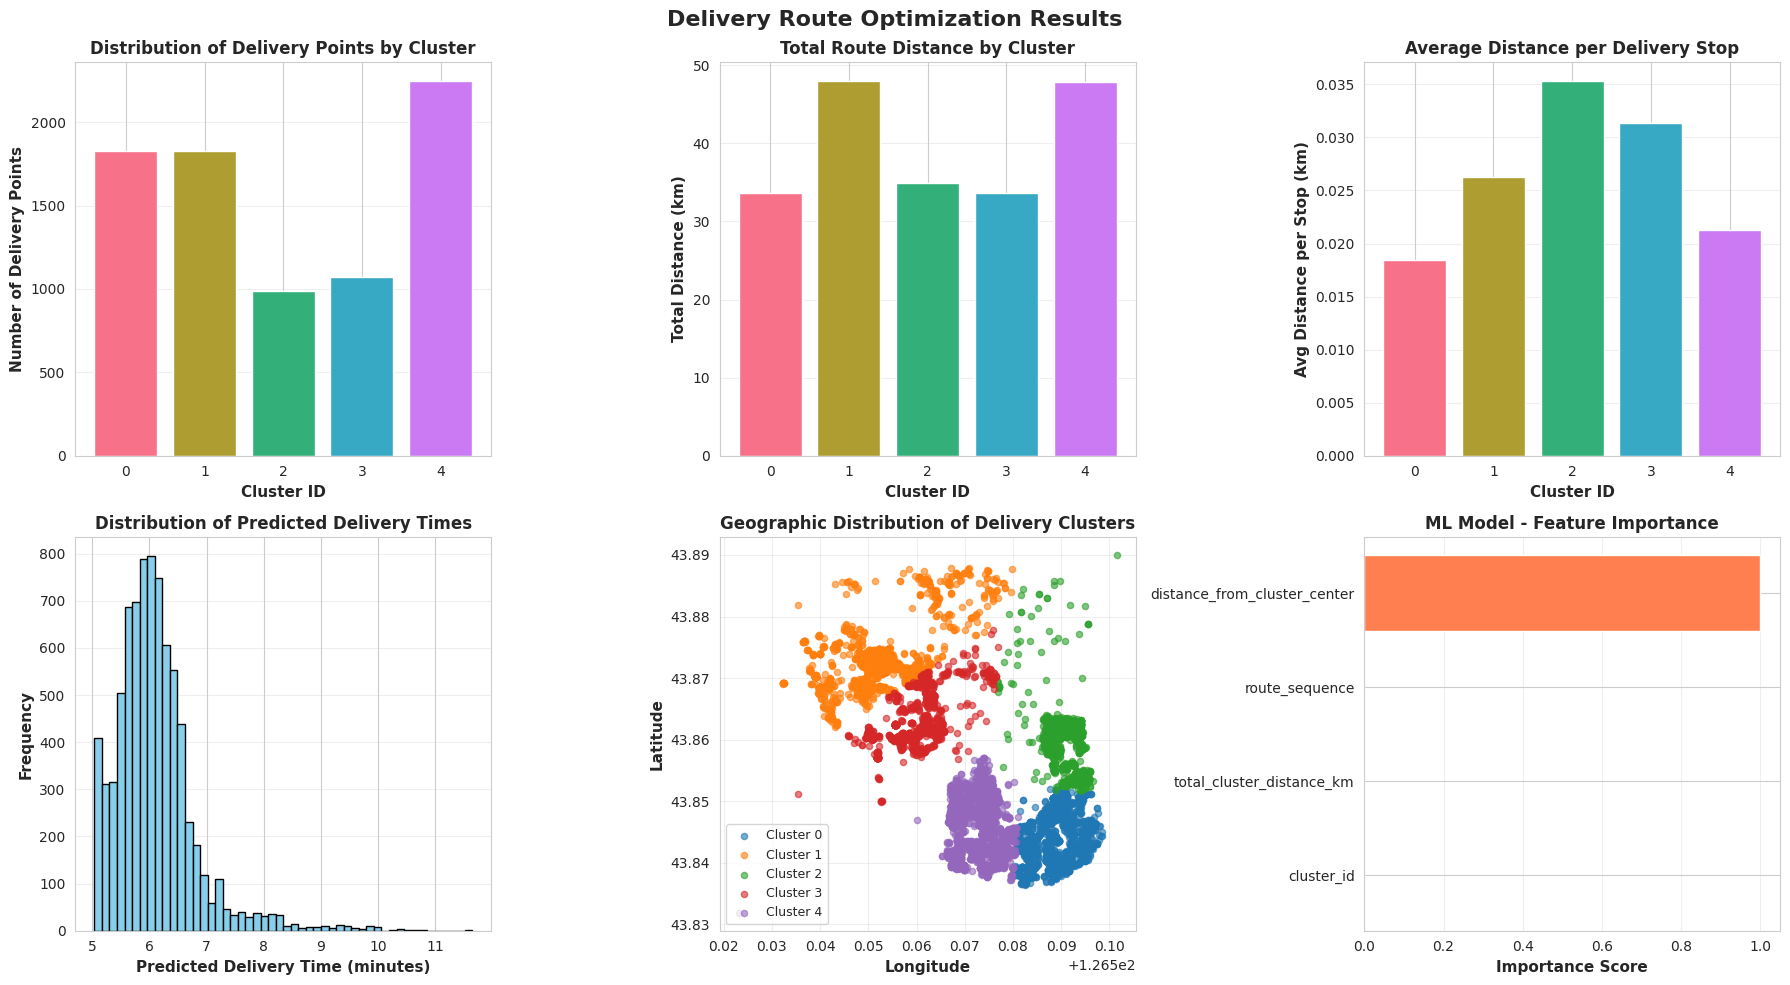


DETAILED CLUSTER STATISTICS

📍 Cluster 0:
   Points: 1828
   Distance: 33.65 km
   Avg distance/stop: 0.0184 km
   Avg delivery time: 6.04 min
   Geographic bounds:
      Lat: [43.8364, 43.8519]
      Lon: [126.5802, 126.5984]

📍 Cluster 1:
   Points: 1826
   Distance: 47.98 km
   Avg distance/stop: 0.0263 km
   Avg delivery time: 6.17 min
   Geographic bounds:
      Lat: [43.8620, 43.8879]
      Lon: [126.5323, 126.5797]

📍 Cluster 2:
   Points: 989
   Distance: 34.92 km
   Avg distance/stop: 0.0353 km
   Avg delivery time: 6.02 min
   Geographic bounds:
      Lat: [43.8517, 43.8900]
      Lon: [126.5767, 126.6015]

📍 Cluster 3:
   Points: 1071
   Distance: 33.62 km
   Avg distance/stop: 0.0314 km
   Avg delivery time: 6.17 min
   Geographic bounds:
      Lat: [43.8499, 43.8778]
      Lon: [126.5353, 126.5768]

📍 Cluster 4:
   Points: 2247
   Distance: 47.84 km
   Avg distance/stop: 0.0213 km
   Avg delivery time: 6.09 min
   Geographic bounds:
      Lat: [43.8319, 43.8571]
      Lon

In [17]:
# Visualize optimization results
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("VISUALIZATION OF OPTIMIZATION RESULTS")
print("=" * 60)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Delivery Route Optimization Results', fontsize=16, fontweight='bold')

# 1. Cluster distribution
ax1 = axes[0, 0]
cluster_counts = df_clean['cluster'].value_counts().sort_index()
colors = sns.color_palette("husl", len(cluster_counts))
ax1.bar(cluster_counts.index, cluster_counts.values, color=colors)
ax1.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Delivery Points', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Delivery Points by Cluster', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Distance per cluster
ax2 = axes[0, 1]
ax2.bar(results_df['Cluster'], results_df['Distance (km)'], color=colors)
ax2.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax2.set_ylabel('Total Distance (km)', fontsize=11, fontweight='bold')
ax2.set_title('Total Route Distance by Cluster', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Average distance per stop
ax3 = axes[0, 2]
ax3.bar(results_df['Cluster'], results_df['Avg Distance per Stop (km)'], color=colors)
ax3.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax3.set_ylabel('Avg Distance per Stop (km)', fontsize=11, fontweight='bold')
ax3.set_title('Average Distance per Delivery Stop', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Predicted delivery time distribution
ax4 = axes[1, 0]
ax4.hist(optimized_routes_df['predicted_delivery_time_min'], bins=50, color='skyblue', edgecolor='black')
ax4.set_xlabel('Predicted Delivery Time (minutes)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Predicted Delivery Times', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5. Geographic distribution of clusters
ax5 = axes[1, 1]
for cluster_id in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    ax5.scatter(cluster_data['lng'], cluster_data['lat'], 
               label=f'Cluster {cluster_id}', s=20, alpha=0.6)
ax5.set_xlabel('Longitude', fontsize=11, fontweight='bold')
ax5.set_ylabel('Latitude', fontsize=11, fontweight='bold')
ax5.set_title('Geographic Distribution of Delivery Clusters', fontsize=12, fontweight='bold')
ax5.legend(loc='best', fontsize=9)
ax5.grid(alpha=0.3)

# 6. Feature importance
ax6 = axes[1, 2]
feature_imp_sorted = feature_importance.sort_values('Importance', ascending=True)
ax6.barh(feature_imp_sorted['Feature'], feature_imp_sorted['Importance'], color='coral')
ax6.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax6.set_title('ML Model - Feature Importance', fontsize=12, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/home/sirin/BIGDATA/Optimize-Delivery/optimize/result/optimization_visualization.png', 
            dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved to: /home/sirin/BIGDATA/Optimize-Delivery/optimize/result/optimization_visualization.png")
plt.show()

# Additional detailed statistics
print("\n" + "=" * 60)
print("DETAILED CLUSTER STATISTICS")
print("=" * 60)

for cluster_id in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    cluster_routes = optimized_routes_df[optimized_routes_df['cluster_id'] == cluster_id]
    
    print(f"\n📍 Cluster {cluster_id}:")
    print(f"   Points: {len(cluster_data)}")
    print(f"   Distance: {results_df[results_df['Cluster'] == cluster_id]['Distance (km)'].values[0]:.2f} km")
    print(f"   Avg distance/stop: {results_df[results_df['Cluster'] == cluster_id]['Avg Distance per Stop (km)'].values[0]:.4f} km")
    print(f"   Avg delivery time: {cluster_routes['predicted_delivery_time_min'].mean():.2f} min")
    print(f"   Geographic bounds:")
    print(f"      Lat: [{cluster_data['lat'].min():.4f}, {cluster_data['lat'].max():.4f}]")
    print(f"      Lon: [{cluster_data['lng'].min():.4f}, {cluster_data['lng'].max():.4f}]")
